In [5]:
# 1. Manipulação de dados
import pandas as pd
import numpy as np

# 2. Pré-processamento
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# 3. Balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 4. Visualização
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# 5. Modelos de Machine Learning
import xgboost as xgb
from xgboost import XGBClassifier

# 6. Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score,
    f1_score, roc_auc_score, balanced_accuracy_score, average_precision_score,
    log_loss, brier_score_loss, cohen_kappa_score, matthews_corrcoef
)
from sklearn.metrics import precision_recall_curve

# 7. Otimização de hiperparâmetros
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll.base import scope

# 8. Salvamento e carregamento de modelos
import pickle

# Dicionário com as bibliotecas e suas versões
libraries = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "scikit-learn": "sklearn" in globals() and sklearn.__version__,
    "imblearn": SMOTE.__module__.split('.')[0] + " (" + SMOTE.__module__.split('.')[1] + ")",
    "matplotlib": plt.matplotlib.__version__,
    "xgboost": xgb.__version__,
    "hyperopt": fmin.__module__.split('.')[0],
    "pickle": "Built-in library (Python Standard Library)"
}

# Exibindo as versões das bibliotecas
for lib, version in libraries.items():
    print(f"{lib}: {version}")


pandas: 2.1.4
numpy: 1.26.2
scikit-learn: False
imblearn: imblearn (over_sampling)
matplotlib: 3.8.2
xgboost: 2.0.2
hyperopt: hyperopt
pickle: Built-in library (Python Standard Library)


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import matplotlib.patches as mpatches

def psi(data_ref, data_new, num_bins=10, mode='fixed', eps=1e-5):
    """
    Calcula o Population Stability Index (PSI) entre duas distribuições.

    O PSI é utilizado para medir a mudança entre distribuições, sendo amplamente
    empregado para detectar drift populacional em modelos preditivos.

    Parâmetros:
    -----------
    data_ref : array-like
        Dados da distribuição de referência.
    data_new : array-like
        Dados da nova distribuição a ser comparada.
    num_bins : int, opcional
        Número de bins para divisão dos dados (padrão é 10).
    mode : str, opcional
        Modo de criação dos bins ('fixed' para intervalos iguais, 'quantile' para percentis).
    eps : float, opcional
        Valor mínimo utilizado para evitar divisão por zero (padrão é 1e-5).

    Retorna:
    --------
    float
        Valor do PSI calculado.

    Exceções:
    ---------
    ValueError:
        - Caso o modo informado não seja 'fixed' nem 'quantile'.
    """
    data_ref, data_new = np.array(data_ref), np.array(data_new)
    min_val, max_val = min(data_ref.min(), data_new.min()), max(data_ref.max(), data_new.max())

    if np.isclose(min_val, max_val):
        return 0

    if mode == 'fixed':
        bins = np.linspace(min_val, max_val, num_bins + 1)
    elif mode == 'quantile':
        bins = np.unique(np.quantile(data_ref, np.linspace(0, 1, num_bins + 1)))
    else:
        raise ValueError("Modo inválido. Escolha 'fixed' ou 'quantile'.")

    freq_ref = pd.cut(data_ref, bins=bins, include_lowest=True).value_counts(normalize=True, sort=False).fillna(eps)
    freq_new = pd.cut(data_new, bins=bins, include_lowest=True).value_counts(normalize=True, sort=False).fillna(eps)

    psi_values = (freq_new - freq_ref) * np.log(freq_new / freq_ref)

    return psi_values.sum()


def comparative_psi_analysis(datasets, model_features, dataset_names=None):
    """
    Realiza uma análise comparativa utilizando o Population Stability Index (PSI) para avaliar
    mudanças na distribuição das variáveis entre diferentes datasets. Gera um DataFrame com os
    valores de PSI e um heatmap ilustrativo.

    Parâmetros:
    -----------
    datasets : list of pd.DataFrame
        Lista contendo os DataFrames para comparação.
    model_features : list of str
        Lista das variáveis presentes nos datasets a serem analisadas.
    dataset_names : list of str, opcional
        Lista com nomes personalizados para os datasets. Caso não informado, serão gerados
        nomes padrão como Dataset_1, Dataset_2, etc.

    Retorna:
    --------
    pd.DataFrame
        DataFrame contendo os valores de PSI para cada variável e combinação de datasets.

    Exceções:
    ---------
    ValueError:
        - Se o número de datasets não corresponder ao número de nomes informados em dataset_names.
        - Se alguma das variáveis informadas em model_features não estiver presente em algum dataset.
    """
    if dataset_names is None:
        dataset_names = [f'Dataset_{i+1}' for i in range(len(datasets))]

    if len(datasets) != len(dataset_names):
        raise ValueError("O número de datasets deve corresponder ao número de dataset_names.")

    # Validação da existência das variáveis nos datasets
    for feature in model_features:
        for idx, df in enumerate(datasets):
            if feature not in df.columns:
                raise ValueError(f"A variável '{feature}' não está presente no dataset '{dataset_names[idx]}'.")

    psi_results = []

    # Loop pelas variáveis e combinações de datasets para calcular o PSI
    for var in model_features:
        var_results = {'variável': var}
        for (i, df1), (j, df2) in combinations(enumerate(datasets), 2):
            comparison = f'{dataset_names[i]} vs {dataset_names[j]}'
            try:
                psi_value = psi(df1[var], df2[var])
                var_results[comparison] = psi_value
            except Exception as e:
                print(f"Erro no cálculo PSI ({var}, {comparison}): {e}")
                var_results[comparison] = np.nan

        psi_results.append(var_results)

    psi_df = pd.DataFrame(psi_results)

    # Preparação dos dados para o heatmap
    heatmap_data = psi_df.set_index('variável')
    categories = heatmap_data.applymap(lambda x: 0 if x < 0.1 else 1 if x < 0.2 else 2)
    color_map = ['#E5E5E5', '#F2AF72', '#FF7A00']

    # Plotagem do heatmap
    plt.figure(figsize=(14, max(6, len(model_features) * 0.5)))
    sns.heatmap(categories, annot=heatmap_data.round(4), cmap=color_map,
                linewidths=0.5, cbar=False, fmt='')

    plt.title('Population Stability Index (PSI)')
    plt.ylabel('Variáveis')
    plt.xlabel('Comparações')

    # Legenda customizada
    legend_patches = [
        mpatches.Patch(color=color_map[0], label='Pouca mudança (<0.1)'),
        mpatches.Patch(color=color_map[1], label='Mudança moderada (0.1–0.2)'),
        mpatches.Patch(color=color_map[2], label='Mudança significativa (>0.2)')
    ]
    plt.legend(handles=legend_patches, title='PSI', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return psi_df


In [7]:
# Carregar o dataset
file_path = 'df_treinamento_2022_2023.csv'
df = pd.read_csv(file_path)

# Remover colunas desnecessárias
df = df.drop(columns =[ 'codigo_di', 'codigo_tipo_linha','ano'])

# Identificar colunas categóricas
list_dummies = df.drop(columns='status_do_voo').select_dtypes(include=['object']).columns.tolist()

# Transformar colunas categóricas em tipo "category"
df[list_dummies] = df[list_dummies].astype("category")

# Seleção das features preditoras (X) e variável-alvo (y)
dt_ax = df.drop(columns=["status_do_voo"])
dt_ay = df['status_do_voo']

# Codificação da variável-alvo
label_mapping = {'Pontual': 0, 'Atrasado': 1}
dt_ay = dt_ay.map(label_mapping)

# Divisão em treino, validação e teste (70/15/15)
X_train_val, X_test, y_train_val, y_test = train_test_split(dt_ax, dt_ay, test_size=0.15, random_state=33)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=33)

In [9]:
file_path = 'df_predicao_ootv_2024.csv'
df_oot = pd.read_csv(file_path)
df_oot = df_oot.drop(columns=["status_do_voo"])

In [ ]:
list(X_train)

In [12]:
# Atualizar os nomes das colunas (features)
feature_names = list(X_train.columns)


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from itertools import combinations

def comparative_psi_analysis(datasets, model_features, dataset_names=None):
    def psi(data_ref, data_new, num_bins=10, mode='fixed', eps=1e-5):
        data_ref = np.array(data_ref)
        data_new = np.array(data_new)
        min_val = min(np.min(data_ref), np.min(data_new))
        max_val = max(np.max(data_ref), np.max(data_new))
        if np.isclose(min_val, max_val):
            return 0
        if mode == 'fixed':
            bins = np.linspace(min_val, max_val, num_bins + 1)
        elif mode == 'quantile':
            bins = np.unique(np.quantile(data_ref, np.linspace(0, 1, num_bins + 1)))
        else:
            raise ValueError('Invalid mode')
        bins_ref = pd.cut(data_ref, bins=bins, labels=False, include_lowest=True)
        bins_new = pd.cut(data_new, bins=bins, labels=False, include_lowest=True)
        freq_ref = pd.Series(bins_ref).value_counts(normalize=True, sort=False).fillna(eps)
        freq_new = pd.Series(bins_new).value_counts(normalize=True, sort=False).fillna(eps)
        freq_ref = freq_ref.reindex(range(len(bins) - 1), fill_value=eps)
        freq_new = freq_new.reindex(range(len(bins) - 1), fill_value=eps)
        psi_values = (freq_new - freq_ref) * np.log(freq_new / freq_ref)
        return psi_values.sum()

    if dataset_names is None:
        dataset_names = [f'Dataset_{i + 1}' for i in range(len(datasets))]
    
    if len(datasets) != len(dataset_names):
        raise ValueError("Number of datasets must match number of dataset names")

    psi_results = []
    for var in model_features:
        var_results = {'var': var}
        for (i, df1), (j, df2) in combinations(enumerate(datasets), 2):
            comparison_name = f'{dataset_names[i]} vs {dataset_names[j]}'
            try:
                psi_value = psi(df1[var], df2[var])
                var_results[comparison_name] = psi_value
            except Exception as e:
                print(f"Erro ao calcular PSI para a variável {var} na comparação {comparison_name}: {str(e)}")
                var_results[comparison_name] = np.nan
        psi_results.append(var_results)

    psi_df = pd.DataFrame(psi_results)

    # Preparar dados para o heatmap
    comparison_columns = [col for col in psi_df.columns if ' vs ' in col]
    psi_melted = psi_df.melt(id_vars='var', value_vars=comparison_columns, var_name='comparison', value_name='psi')

    # Definindo limites para as categorias
    shift_bins = [-np.inf, 0.1, 0.2, np.inf]
    color_map = {0: '#E5E5E5', 1: '#F2AF72', 2: '#FF7A00'}

    # Criar o heatmap
    heatmap_data = psi_melted.pivot(index='var', columns='comparison', values='psi')
    
    # Criar uma lista de cores correspondente aos valores de PSI
    heatmap_data_num = heatmap_data.applymap(lambda x: 
        0 if x < 0.1 else (1 if x < 0.2 else 2))
    
    # Plotar o heatmap
    plt.style.context({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 14})
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(heatmap_data_num, annot=heatmap_data.round(4).astype(str), 
                     cmap=list(color_map.values()), fmt='', linewidths=0.5, cbar=False)

    # Ajustar os limites do colorbar para corresponder às categorias
    ax.collections[0].set_clim(-0.5, 2.5)
    plt.title('Population Stability Index')
    plt.ylabel('Features')
    plt.xlabel(None)
    plt.xticks(rotation=0, ha='center')

    # Criar patches para a legenda com descrições desejadas
    patches = [
        mpatches.Patch(color=color_map[0], label='Little Shift'),
        mpatches.Patch(color=color_map[1], label='Moderate Shift'),
        mpatches.Patch(color=color_map[2], label='Significant Shift'),
    ]
    plt.legend(handles=patches, title='PSI', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Print dos valores de PSI
    print("\nValores de PSI para cada variável:")
    print(psi_df.to_string(index=False, float_format='%.5f'))
    
    return psi_df

In [ ]:
comparative_psi_analysis([X_train,X_val,X_test,df_oot], feature_names, dataset_names=['Treino','Teste','Validação','OoT'])

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from itertools import combinations

def comparative_psi_analysis(datasets, model_features, dataset_names=None):
    def psi(data_ref, data_new, num_bins=10, mode='fixed', eps=1e-5):
        # Se as variáveis forem numéricas:
        if pd.api.types.is_numeric_dtype(data_ref) and pd.api.types.is_numeric_dtype(data_new):
            data_ref = np.array(data_ref)
            data_new = np.array(data_new)
            min_val = min(np.min(data_ref), np.min(data_new))
            max_val = max(np.max(data_ref), np.max(data_new))
            if np.isclose(min_val, max_val):
                return 0
            if mode == 'fixed':
                bins = np.linspace(min_val, max_val, num_bins + 1)
            elif mode == 'quantile':
                bins = np.unique(np.quantile(data_ref, np.linspace(0, 1, num_bins + 1)))
            else:
                raise ValueError('Invalid mode')
            bins_ref = pd.cut(data_ref, bins=bins, labels=False, include_lowest=True)
            bins_new = pd.cut(data_new, bins=bins, labels=False, include_lowest=True)
            freq_ref = pd.Series(bins_ref).value_counts(normalize=True, sort=False).fillna(eps)
            freq_new = pd.Series(bins_new).value_counts(normalize=True, sort=False).fillna(eps)
            # Reindex para garantir a presença de todos os bins
            freq_ref = freq_ref.reindex(range(len(bins) - 1), fill_value=eps)
            freq_new = freq_new.reindex(range(len(bins) - 1), fill_value=eps)
            # Substituir zeros por eps (caso ocorram)
            freq_ref = freq_ref.replace(0, eps)
            freq_new = freq_new.replace(0, eps)
            psi_values = (freq_new - freq_ref) * np.log(freq_new / freq_ref)
            return psi_values.sum()
        else:
            # Tratamento para variáveis categóricas
            # Obter todas as categorias presentes em ambos os conjuntos
            cat_values = np.union1d(np.unique(data_ref), np.unique(data_new))
            freq_ref = pd.Series(data_ref).value_counts(normalize=True).reindex(cat_values, fill_value=eps)
            freq_new = pd.Series(data_new).value_counts(normalize=True).reindex(cat_values, fill_value=eps)
            # Substituir quaisquer zeros por eps para evitar divisão por zero
            freq_ref = freq_ref.replace(0, eps)
            freq_new = freq_new.replace(0, eps)
            psi_values = (freq_new - freq_ref) * np.log(freq_new / freq_ref)
            return psi_values.sum()

    if dataset_names is None:
        dataset_names = [f'Dataset_{i + 1}' for i in range(len(datasets))]
    
    if len(datasets) != len(dataset_names):
        raise ValueError("Number of datasets must match number of dataset names")

    psi_results = []
    for var in model_features:
        var_results = {'var': var}
        for (i, df1), (j, df2) in combinations(enumerate(datasets), 2):
            comparison_name = f'{dataset_names[i]} vs {dataset_names[j]}'
            try:
                psi_value = psi(df1[var], df2[var])
                var_results[comparison_name] = psi_value
            except Exception as e:
                print(f"Erro ao calcular PSI para a variável {var} na comparação {comparison_name}: {str(e)}")
                var_results[comparison_name] = np.nan
        psi_results.append(var_results)

    psi_df = pd.DataFrame(psi_results)

    # Preparar dados para o heatmap
    comparison_columns = [col for col in psi_df.columns if ' vs ' in col]
    psi_melted = psi_df.melt(id_vars='var', value_vars=comparison_columns, var_name='comparison', value_name='psi')

    # Definir limites para categorização dos valores de PSI
    shift_bins = [-np.inf, 0.1, 0.2, np.inf]
    color_map = {0: '#E5E5E5', 1: '#F2AF72', 2: '#FF7A00'}

    # Criar a matriz para o heatmap
    heatmap_data = psi_melted.pivot(index='var', columns='comparison', values='psi')
    
    # Converter os valores de PSI para categorias conforme os limites definidos
    heatmap_data_num = heatmap_data.applymap(lambda x: 0 if x < 0.1 else (1 if x < 0.2 else 2))
    
    # Plotar o heatmap
    plt.style.context({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 14})
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(heatmap_data_num, annot=heatmap_data.round(5).astype(str), 
                     cmap=list(color_map.values()), fmt='', linewidths=0.5, cbar=False)

    # Ajustar os limites do colorbar para corresponder às categorias
    ax.collections[0].set_clim(-0.5, 2.5)
    plt.title('Population Stability Index')
    plt.ylabel('Features')
    plt.xlabel(None)
    plt.xticks(rotation=0, ha='center')

    # Criar patches para a legenda
    patches = [
        mpatches.Patch(color=color_map[0], label='Little Shift'),
        mpatches.Patch(color=color_map[1], label='Moderate Shift'),
        mpatches.Patch(color=color_map[2], label='Significant Shift'),
    ]
    plt.legend(handles=patches, title='PSI', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Exibir os valores de PSI para cada variável
    print("\nValores de PSI para cada variável:")
    print(psi_df.to_string(index=False, float_format='%.5f'))
    
    return psi_df


In [22]:
"""
Módulo: Análise Comparativa do PSI (Population Stability Index)

Este módulo contém a função `comparative_psi_analysis` que realiza a análise do 
Population Stability Index (PSI) entre diferentes datasets para variáveis 
selecionadas (model_features). A função compara os datasets de forma par a par e 
gera um heatmap para visualização dos resultados.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from itertools import combinations

def comparative_psi_analysis(datasets, model_features, dataset_names=None):
    """
    Realiza a análise comparativa do PSI para variáveis especificadas entre 
    diferentes datasets e gera um heatmap para visualização das diferenças.

    Parameters:
    -----------
    datasets : list of pandas.DataFrame
        Lista de dataframes contendo os dados que serão comparados.
        
    model_features : list of str
        Lista com os nomes das colunas (variáveis) que serão analisadas.
        
    dataset_names : list of str, optional
        Lista de nomes para os datasets. Se None, os nomes serão gerados 
        automaticamente como 'Dataset_1', 'Dataset_2', ... com base na quantidade de datasets.

    Returns:
    --------
    psi_df : pandas.DataFrame
        DataFrame contendo os valores do PSI para cada variável, com cada 
        coluna representando a comparação entre dois datasets.

    Raises:
    -------
    ValueError:
        Se o número de datasets for diferente do número de nomes passados em 
        `dataset_names`.
    """

    def psi(data_ref, data_new, num_bins=10, mode='fixed', eps=1e-5):
        """
        Calcula o Population Stability Index (PSI) entre duas distribuições.

        A função trata tanto variáveis numéricas quanto categóricas. Para variáveis 
        numéricas, o cálculo é feito a partir de discretizações em bins definidos por 
        intervalo fixo ou quantil. Para variáveis categóricas, o cálculo é feito a partir 
        das frequências relativas das categorias.

        Parameters:
        -----------
        data_ref : array-like
            Dados de referência (base) para a comparação.
            
        data_new : array-like
            Novos dados para comparar com a referência.
            
        num_bins : int, default=10
            Número de bins a serem usados para variáveis numéricas no modo 'fixed'.
            
        mode : {'fixed', 'quantile'}, default='fixed'
            Modo de criação dos bins para variáveis numéricas. 'fixed' usa intervalo fixo e 
            'quantile' usa quantis da distribuição de referência.
            
        eps : float, default=1e-5
            Valor pequeno usado para substituir zeros e evitar divisões por zero.

        Returns:
        --------
        psi_value : float
            Valor calculado do PSI para as distribuições comparadas.
        """
        # Verifica se ambas as variáveis são numéricas
        if pd.api.types.is_numeric_dtype(data_ref) and pd.api.types.is_numeric_dtype(data_new):
            data_ref = np.array(data_ref)
            data_new = np.array(data_new)
            
            # Define os limites mínimo e máximo para criar os bins
            min_val = min(np.min(data_ref), np.min(data_new))
            max_val = max(np.max(data_ref), np.max(data_new))
            
            # Se os valores mínimo e máximo forem iguais, não há variação, logo PSI é zero
            if np.isclose(min_val, max_val):
                return 0
            
            # Definir os bins com base no modo especificado
            if mode == 'fixed':
                bins = np.linspace(min_val, max_val, num_bins + 1)
            elif mode == 'quantile':
                bins = np.unique(np.quantile(data_ref, np.linspace(0, 1, num_bins + 1)))
            else:
                raise ValueError('Modo inválido. Utilize "fixed" ou "quantile".')

            # Atribuir cada valor a um bin
            bins_ref = pd.cut(data_ref, bins=bins, labels=False, include_lowest=True)
            bins_new = pd.cut(data_new, bins=bins, labels=False, include_lowest=True)
            
            # Calcula as frequências normalizadas para cada bin
            freq_ref = pd.Series(bins_ref).value_counts(normalize=True, sort=False).fillna(eps)
            freq_new = pd.Series(bins_new).value_counts(normalize=True, sort=False).fillna(eps)
            
            # Garante que todos os bins estejam presentes
            freq_ref = freq_ref.reindex(range(len(bins) - 1), fill_value=eps)
            freq_new = freq_new.reindex(range(len(bins) - 1), fill_value=eps)
            
            # Substitui eventuais zeros pelo valor de eps
            freq_ref = freq_ref.replace(0, eps)
            freq_new = freq_new.replace(0, eps)
            
            # Calcula o PSI para cada bin e retorna a soma dos valores
            psi_values = (freq_new - freq_ref) * np.log(freq_new / freq_ref)
            return psi_values.sum()
        else:
            # Tratamento para variáveis categóricas
            # Obter todas as categorias presentes em ambos os conjuntos
            cat_values = np.union1d(np.unique(data_ref), np.unique(data_new))
            freq_ref = pd.Series(data_ref).value_counts(normalize=True).reindex(cat_values, fill_value=eps)
            freq_new = pd.Series(data_new).value_counts(normalize=True).reindex(cat_values, fill_value=eps)
            
            # Substituir zeros por eps para evitar divisão por zero
            freq_ref = freq_ref.replace(0, eps)
            freq_new = freq_new.replace(0, eps)
            
            # Calcula e retorna o valor do PSI
            psi_values = (freq_new - freq_ref) * np.log(freq_new / freq_ref)
            return psi_values.sum()

    # Se não forem informados nomes para os datasets, gera nomes automáticos
    if dataset_names is None:
        dataset_names = [f'Dataset_{i + 1}' for i in range(len(datasets))]
    
    # Validação: o número de datasets deve ser igual ao número de nomes
    if len(datasets) != len(dataset_names):
        raise ValueError("Number of datasets must match number of dataset names")
    
    psi_results = []  # Lista para armazenar os resultados do PSI por variável
    
    # Realiza comparações par a par entre os datasets para cada variável em model_features
    for var in model_features:
        var_results = {'var': var}  # Dicionário que armazenará os resultados para a variável atual
        for (i, df1), (j, df2) in combinations(enumerate(datasets), 2):
            comparison_name = f'{dataset_names[i]} vs {dataset_names[j]}'
            try:
                # Calcula o PSI para a variável 'var' entre os dois datasets
                psi_value = psi(df1[var], df2[var])
                var_results[comparison_name] = psi_value
            except Exception as e:
                # Em caso de erro, imprime uma mensagem e armazena NaN para a comparação
                print(f"Erro ao calcular PSI para a variável {var} na comparação {comparison_name}: {str(e)}")
                var_results[comparison_name] = np.nan
        psi_results.append(var_results)
    
    # Converte os resultados para um DataFrame do pandas
    psi_df = pd.DataFrame(psi_results)

    # Prepara os dados para gerar um heatmap (valores de PSI por comparação)
    comparison_columns = [col for col in psi_df.columns if ' vs ' in col]
    psi_melted = psi_df.melt(id_vars='var', value_vars=comparison_columns, 
                             var_name='comparison', value_name='psi')

    # Define os intervalos para categorização dos valores do PSI:
    # - Valores menores que 0.1 indicam "Little Shift"
    # - Valores entre 0.1 e 0.2 indicam "Moderate Shift"
    # - Valores maiores ou iguais a 0.2 indicam "Significant Shift"
    shift_bins = [-np.inf, 0.1, 0.2, np.inf]
    
    # Mapeamento para as cores a serem usadas no heatmap
    color_map = {
    0: '#D3D3D3',  # Pouca mudança
    1: '#C0A080',  # Mudança moderada
    2: '#FF6347'   # Mudança significativa
    }
    
    # Reestrutura os dados para criar uma matriz (pivot) para o heatmap, onde as linhas são as variáveis e 
    # as colunas as comparações
    heatmap_data = psi_melted.pivot(index='var', columns='comparison', values='psi')
    
    # Converte os valores de PSI para categorias (0, 1 ou 2) de acordo com os intervalos definidos
    heatmap_data_num = heatmap_data.applymap(lambda x: 0 if x < 0.1 else (1 if x < 0.2 else 2))
    
    # Configurações de estilo para o plot do heatmap
    plt.style.context({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 14})
    plt.figure(figsize=(14, 8))
    
    # Cria o heatmap utilizando o seaborn, utilizando os valores categorizados para definir as cores
    ax = sns.heatmap(
        heatmap_data_num,
        annot=heatmap_data.round(5).astype(str),  # Anotação com valores do PSI formatados
        cmap=list(color_map.values()),
        fmt='',
        linewidths=0.5,
        cbar=False
    )

    # Ajusta os limites do colorbar para que correspondam às categorias
    ax.collections[0].set_clim(-0.5, 2.5)
    
    # Configura título e rótulos dos eixos
    plt.title('Population Stability Index')
    plt.ylabel('Features')
    plt.xlabel(None)
    plt.xticks(rotation=0, ha='center')

    # Cria patches para a legenda com base no mapeamento de cores definido
    patches = [
        mpatches.Patch(color=color_map[0], label='Little Shift'),
        mpatches.Patch(color=color_map[1], label='Moderate Shift'),
        mpatches.Patch(color=color_map[2], label='Significant Shift'),
    ]
    plt.legend(handles=patches, title='PSI', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    
    # Exibe o heatmap
    plt.show()

    # Imprime os valores do PSI para cada variável no console
    print("\nValores de PSI para cada variável:")
    print(psi_df.to_string(index=False, float_format='%.5f'))
    
    return psi_df


C:\Users\pedro\AppData\Local\Temp\ipykernel_35444\637232305.py:185: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_data_num = heatmap_data.applymap(lambda x: 0 if x < 0.1 else (1 if x < 0.2 else 2))


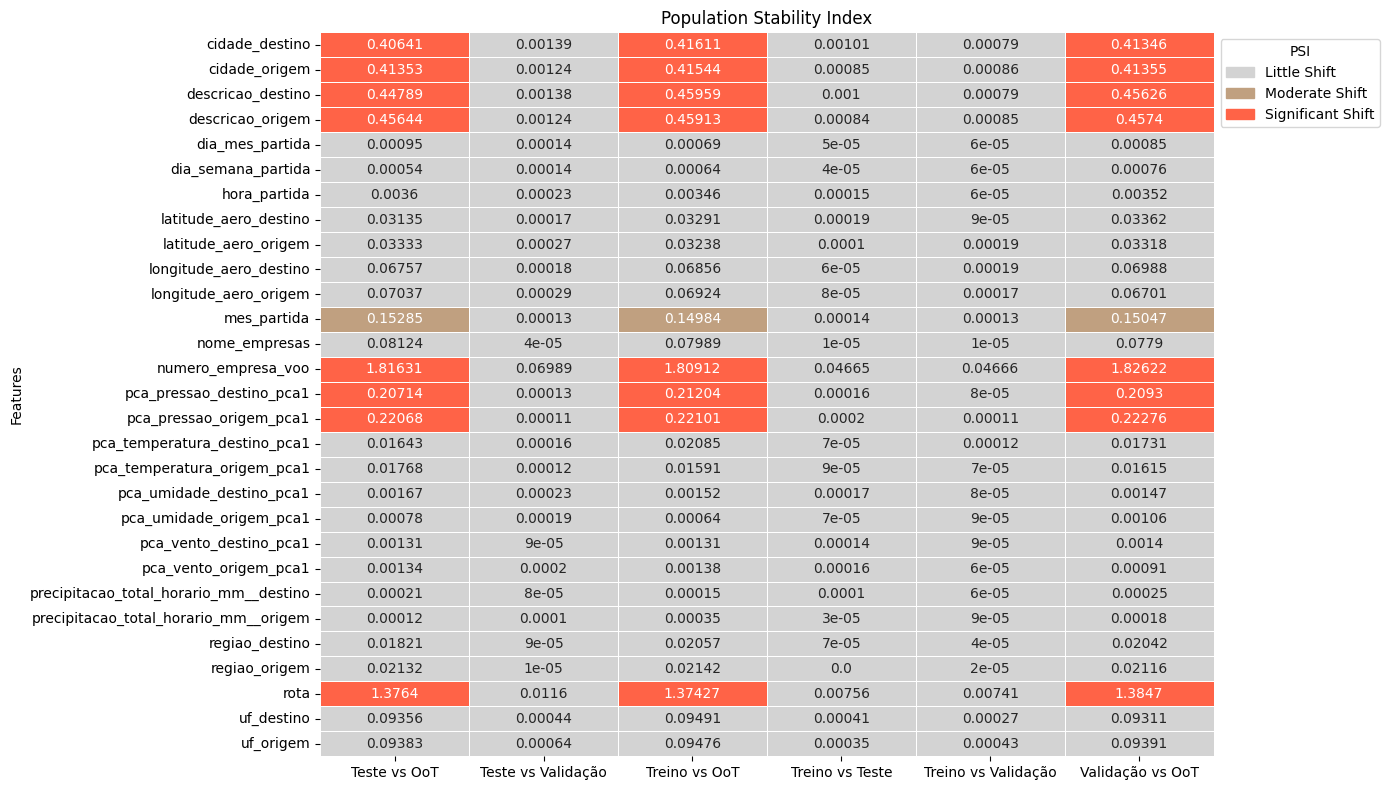


Valores de PSI para cada variável:
                                   var  Treino vs Teste  Treino vs Validação  Treino vs OoT  Teste vs Validação  Teste vs OoT  Validação vs OoT
                         nome_empresas          0.00001              0.00001        0.07989             0.00004       0.08124           0.07790
                      descricao_origem          0.00084              0.00085        0.45913             0.00124       0.45644           0.45740
                     descricao_destino          0.00100              0.00079        0.45959             0.00138       0.44789           0.45626
                         cidade_origem          0.00085              0.00086        0.41544             0.00124       0.41353           0.41355
                             uf_origem          0.00035              0.00043        0.09476             0.00064       0.09383           0.09391
                        cidade_destino          0.00101              0.00079        0.41611         

,var,Treino vs Teste,Treino vs Validação,Treino vs OoT,Teste vs Validação,Teste vs OoT,Validação vs OoT
0,nome_empresas,0.000006,0.000013,0.079891,0.000035,0.081244,0.077900
1,descricao_origem,0.000843,0.000851,0.459133,0.001245,0.456436,0.457396
2,descricao_destino,0.001003,0.000791,0.459589,0.001376,0.447892,0.456257
3,cidade_origem,0.000846,0.000857,0.415444,0.001241,0.413530,0.413546
4,uf_origem,0.000348,0.000434,0.094756,0.000639,0.093835,0.093912
5,cidade_destino,0.001012,0.000788,0.416109,0.001391,0.406415,0.413455
6,uf_destino,0.000414,0.000270,0.094911,0.000445,0.093556,0.093115
7,mes_partida,0.000142,0.000127,0.149836,0.000130,0.152848,0.150469
8,dia_semana_partida,0.000043,0.000058,0.000636,0.000139,0.000539,0.000764
9,dia_mes_partida,0.000053,0.000057,0.000690,0.000136,0.000952,0.000850


In [23]:
comparative_psi_analysis([X_train,X_val,X_test,df_oot], feature_names, dataset_names=['Treino','Teste','Validação','OoT'])